In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Predict a chest disease

In [3]:
import sys
sys.path.append("../../fastai/")

In [4]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

In [5]:
#PATH = "/home/sathiesh/skole_ai/dataset/NIH-chest-xrays/data/"  #MMIV
PATH = "/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/" #Hjemme 

In [6]:
sz=112
arch=dn121 #trent opp på ImageNet
bs = 16

In [7]:
label_csv = f'{PATH}Data_Entry_2017.csv' 

In [8]:
os.listdir(PATH)

['labels.csv',
 '.DS_Store',
 'Data_Entry_2017.csv',
 'test_list.txt',
 '.ipynb_checkpoints']

In [9]:
df = pd.read_csv(label_csv)

# Feature engineering and data cleaning 

In [10]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalHeight,OriginalImagePixelSpacingx,OriginalImagePixelSpacingy,Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [11]:
df = df.drop(['Follow-up #','Patient ID', 'Patient Age', 'Patient Gender', 'View Position',
              'OriginalImageWidth', 'OriginalHeight', 'OriginalImagePixelSpacingx', 'OriginalImagePixelSpacingy', 'Unnamed: 11'],axis=1)
df.head()

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia


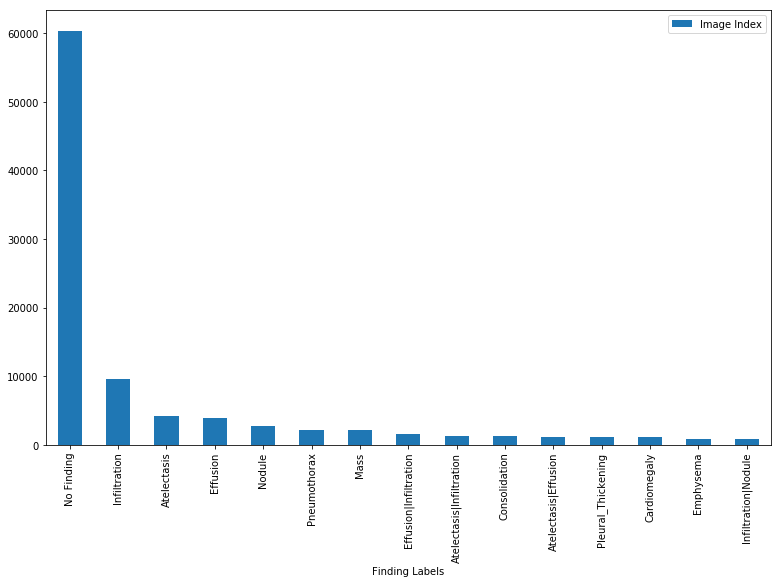

In [12]:
df_sorted = df.pivot_table(index='Finding Labels', aggfunc=len).sort_values('Image Index', ascending=False) 
df_sorted[0:15].plot(kind='bar',figsize=(13,8))

In [13]:
df_sorted.head()

,Image Index
Finding Labels,
No Finding,60361
Infiltration,9547
Atelectasis,4215
Effusion,3955
Nodule,2705


In [14]:
disease_name = 'Effusion'
df_disease = df_sorted[df_sorted.index.str.contains(disease_name)]
disease_row = df_sorted.loc[disease_name]['Image Index']
total_apperance = sum(df_disease['Image Index'])
print(disease_name +': ' + str(disease_row) + '\n'+ 'Total apperance: ' + str(total_apperance)+ '\n'
      +'Number of rows that must be deleted: ' + (str)(total_apperance - disease_row))

Effusion: 3955
Total apperance: 13317
Number of rows that must be deleted: 9362


In [15]:
temp_df = df
temp_df['searching_disease'] = temp_df['Finding Labels'].str.contains(disease_name) #finne alle 
temp_df = temp_df[temp_df['searching_disease']]; #dataframe med alle de vi søker etter 

#Finner alle ordene selvom jeg legger til | oppe, så må gjøre det slik i stedet.  
temp_df['Finding Labels'] = temp_df['Finding Labels'].str.replace('|','REMOVE')
temp_df['searching_disease'] = temp_df['Finding Labels'].str.contains('REMOVE')
arr = np.array(temp_df[temp_df['searching_disease']].index) #alle som er lablet som disease + noe annet
arr.size 
#hvorfor blir searching_disease lagt til df? 
#df.head()

/Users/Sathiesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/Sathiesh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


9362

In [16]:
df = df.drop(arr)#vil ha nan verdier når man gjør dette. 
df = df.reset_index(drop=True)

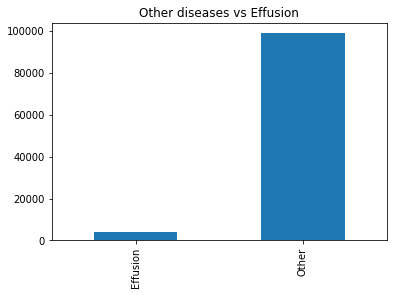

In [17]:
#legge sammen alle som er false og alle som er true i hver sin 
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [18]:
df_sorted

,Finding Labels,Image Index
Effusion,3955,3955
Other,98803,98803


In [19]:
disease_count = df_sorted['Image Index'][0]
other_disease_count = df_sorted['Image Index'][1]
ratio = (other_disease_count// disease_count)-1
df = df.append([df[df.searching_disease]]*ratio, ignore_index=True) #df.searching_disease: array m true, false 
ratio
#for effusion er man egentlig nærme nærme en ratio på 1:25

23

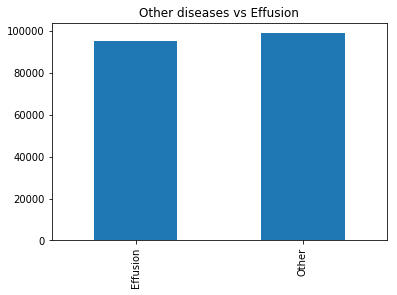

In [20]:
df_sorted = df.pivot_table(index='searching_disease', aggfunc=len).sort_values('Image Index') 
df_sorted.index = [disease_name,'Other']
df_sorted['Image Index'].plot(kind='bar', title="Other diseases vs "+disease_name)

In [21]:
#Testsettet blir valideringssett siden valideringssettet vi lager med treningssettet kan inneholde bilder av samme
#passient, dermed gir den bedre predikasjon på valideringssettet enn det som vil bli med testsettet
val_image_name_list = [line.rstrip('\n') for line in open(f'{PATH}test_list.txt')]
len(val_image_name_list),val_image_name_list[:5]

(25596,
 ['00000003_000.png',
  '00000003_001.png',
  '00000003_002.png',
  '00000003_003.png',
  '00000003_004.png'])

In [22]:
#indeksene til alle de som skal være i valideringssettet
val_idxs = df[df['Image Index'].isin(val_image_name_list)].index 
len(val_idxs)

48946

In [23]:
#DETTE er bare en test på et bilde som inneholder effusion for å sjekke at det finnes 24 indeks av den. 
#TODO: Skal slettes
test = df[df['Image Index'].isin(val_image_name_list)]
test[test['Image Index'].str.contains('00029813_033.png')].shape #et bilde som inneholder effusion

(24, 3)

In [24]:
print('validation set: ' +str(len(val_idxs)/df.index.size) +'%')

validation set: 0.2526597254843256%


In [25]:
df = df.drop(['Finding Labels'], axis=1)

In [26]:
df.head()

,Image Index,searching_disease
0,00000001_000.png,False
1,00000001_001.png,False
2,00000002_000.png,False
3,00000003_000.png,False
4,00000003_001.png,False


In [27]:
cleaned_label_path = f'{PATH}labels.csv'
df.to_csv(cleaned_label_path, index=False) #lagres i en annen dir

# View data 

In [28]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on)
    return ImageClassifierData.from_csv(PATH, 'train', cleaned_label_path, test_name=None,
                                       val_idxs=val_idxs, tfms=tfms,bs=bs);

In [29]:
data = get_data(sz)

In [30]:
fn = PATH+data.trn_ds.fnames[0]
fn 

'/Users/Sathiesh/MachineLearning/Deep_Learning_Kaliy/my_projects/chest-xrays/data/train/00000001_000.png'

In [31]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((144777,), (48946,))

In [ ]:
img = PIL.Image.open(fn);
img

In [ ]:
img.size

In [ ]:
#size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames} #størrelsene på alle bildene 

In [ ]:
#row_sz, col_sz = list(zip(*size_d.values())) #skjønne hva denne gjør

In [ ]:
#row_sz = np.array(row_sz)
#col_sz = np.array(col_sz)

In [ ]:
#row_sz

In [ ]:
#plt.hist(row_sz)

In [ ]:
data.classes[:2]

In [ ]:
#data = get_data(sz,bs); #fikk feilmelding før om at bildet ikke lå i tmp...

# Training

In [ ]:
learn = ConvLearner.pretrained(arch, data)#, ps=0.5)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(lr, 3, cycle_len=1)

In [ ]:
learn.unfreeze()

In [ ]:
#learn.lr_find()
#learn.sched.plot()

In [ ]:
lrs = [lr/9, lr/3,lr];

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2) #brukte lr i stedet for lrs, så det forverret nettet

In [ ]:
learn.save(f'{sz}') 

In [ ]:
sz=224

In [ ]:
learn.set_data(get_data(sz))
learn.freeze() 
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.lr_find()

In [ ]:
learn.sched.plot()

In [ ]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2) 

In [ ]:
learn.save(f'{sz}')

In [ ]:
sz = 299

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

#  Analyzing the results

In [ ]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),axis=0)

accuracy_np(probs, y)

In [ ]:
probs

In [ ]:
preds = np.argmax(probs, axis=1)  # from log probabilities to 0 or 1 #arg max velger posisjonen til den med høyest verdi. Altså enten posisjon 0 eller 1 i dette tilfelle
probs = probs[:,1]        # pr(pneumonia)

In [ ]:
cm = confusion_matrix(y,preds); #sklearn method 

In [ ]:
plot_confusion_matrix(cm,['other', 'pneumonia'])


In [ ]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect pneumonia")